# Agents Coursework

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Predator-prey

Building on the CSA model for a flock of agents in lab 2, we now want to study how behaviour changes if a different type of agent is introduced: a predator.

The predator agent will be faster than the agents in the flock. Again it will move at constant speed, which will be $50%$ greater than that of the flock members. However, the predator will be less nimble. Whilst the flock members will be able to change heading every step (which will always be $\Delta t = 0.05$), the predator will only be able to change heading every $4$ steps.

The predator will obey the same cohesion and alignment rules as the flock, but will not try and maintain separation. That is, the predator utility function will be

\begin{equation}
  f_{\text{predator}} \left( \theta ; {\bf z}, {\bf z}_i, {\bf v}_i \right) = C \cos(\theta - \theta_z) + A \cos(\theta - \theta_V).
\end{equation}

If the predator gets within a distance $r_{\text{eat}}$ of a flock member, the flock member is "eaten" and removed from the simulation. The predator "sees" the whole flock: its locality radius is $r_l = \infty$.

The utility function of members of the flock remains, as in lab 2,

\begin{equation}
  f_{\text{flock}} \left( \theta ; {\bf z}, {\bf z}_i, {\bf v}_i \right) = C \cos(\theta - \theta_z) + A \cos(\theta - \theta_V) - S \frac{\cos(\theta - \theta_{z_{\text{min}}})}{\Delta z_{\text{min}}^2 }.
\end{equation}

The flock members will avoid the predator in the same way they avoid other members of the flock - via the separation term.

In [2]:
%matplotlib inline
import math
import numpy
from matplotlib import pyplot, animation
from JSAnimation import IPython_display

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (8,8)

import scipy
from scipy.optimize import minimize

from __future__ import division

Start with a flock of $100$ agents in an array within $[0, 5]^2$, all moving "due north". Start the predator at $(15, 15)$ with velocity "due west":

/home/kostas/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


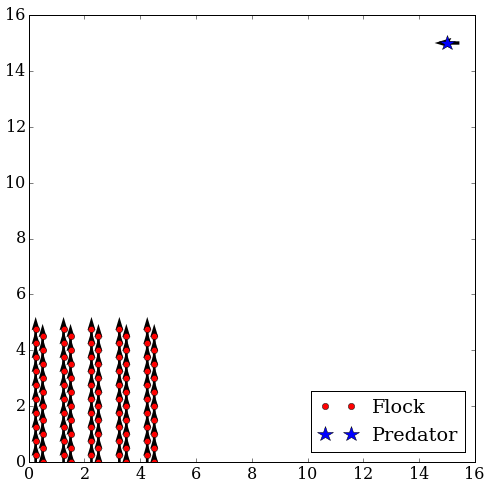

In [3]:
x = numpy.linspace(0, 4.5, 10)
[locations_flock_x, locations_flock_y] = numpy.meshgrid(x, x)
locations_flock_x[:,::2] += 0.25
locations_flock_y[:,::2] += 0.25
locations = numpy.vstack((numpy.ravel(locations_flock_x), numpy.ravel(locations_flock_y))).T
velocities = numpy.zeros_like(locations)
velocities[:,1] = 1.0
location_predator = numpy.array([15.0, 15.0])
velocity_predator = numpy.array([-2.0, 0.0])
pyplot.plot(locations[:,0], locations[:,1], 'ro', label='Flock')
pyplot.quiver(locations[:,0], locations[:,1], velocities[:,0], velocities[:,1], pivot='mid', units='xy')
pyplot.plot(15, 15, 'b*', markersize=16, label='Predator')
pyplot.quiver(location_predator[0], location_predator[1], velocity_predator[0], velocity_predator[1], pivot='mid', units='xy')
pyplot.legend(loc='lower right')
pyplot.show()

Fix the cohesion and alignment parameters for both the predator to be $C = 1, A = 10^{-2}$, and for the flock to be $C = 1, A = 5$. Show how the separation parameter $S$ for the flock changes the number of the flock that survive in evolutions up to $t=50$. A (small!) range of $S$ between $10^{-3}$ and $100$ should be considered.